<a href="https://colab.research.google.com/github/jkwakyi/Student-Predictions/blob/main/Student_Placement_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Student Placement Predictor**

**Goal**: I would like to identify which factors most influenced a candidate getting placed or not.

## **Obtain**

In [2]:
# Mount Data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import set_config, metrics
set_config(display = 'diagram')
!pip install openpyxl==3.0.0

In [48]:
 # load dataset
 
df = pd.read_excel('/content/drive/MyDrive/Coding Dojo/Data/Placement_Data_Full_Class.xlsx')

df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


* sl_no = Serial Number
* gender = gender
  * Male = M
  * Felame = F
* ssc_p = Secondary Education percentage
* ssc_b = Board of Education
* hsc_p = Higher Secondary Education percentage


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


**Numerical**: 'sl_no' 'ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'salary'

**Ordinal**: 'workex', 'status'

**Nominal**: 'gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'mba_p'

## **Scrub**

In [52]:
# drop salary column & set serial number as index

df.set_index(['sl_no'], drop = True, inplace = True)
df = df.drop(columns = 'salary')
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


* I made the serial number column the index.

* I dropped the Salary column because they the salary was dependant on if a student was placed or not. 
  * If a student wasn't placed, they would get NaN in the data

In [57]:
print('Placement Status:\n', df['status'].value_counts())
print('\n')
print('Work Experience:\n', df['workex'].value_counts())

Placement Status:
 Placed        148
Not Placed     67
Name: status, dtype: int64


Work Experience:
 No     141
Yes     74
Name: workex, dtype: int64


In [58]:
# ordinal encode workex and status

replace_workex = {'No': 0, 'Yes': 1}
df['workex'].replace(replace_workex, inplace = True)

replace_status = {'Placed': 1, 'Not Placed': 0}
df['status'].replace(replace_status, inplace = True)

df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,0,55.0,Mkt&HR,58.80,1
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,1,86.5,Mkt&Fin,66.28,1
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,0,75.0,Mkt&Fin,57.80,1
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,0,66.0,Mkt&HR,59.43,0
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,0,96.8,Mkt&Fin,55.50,1


In [59]:
print('Placement Status:\n', df['status'].value_counts())
print('\n')
print('Work Experience:\n', df['workex'].value_counts())

Placement Status:
 1    148
0     67
Name: status, dtype: int64


Work Experience:
 0    141
1     74
Name: workex, dtype: int64


In [60]:
# check for duplicates

df[df.duplicated(keep = False)]

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,


No duplicate columns

No duplicate rows

Missing Values in the salary column

No inconsistancies

No outliers

## **Explore**

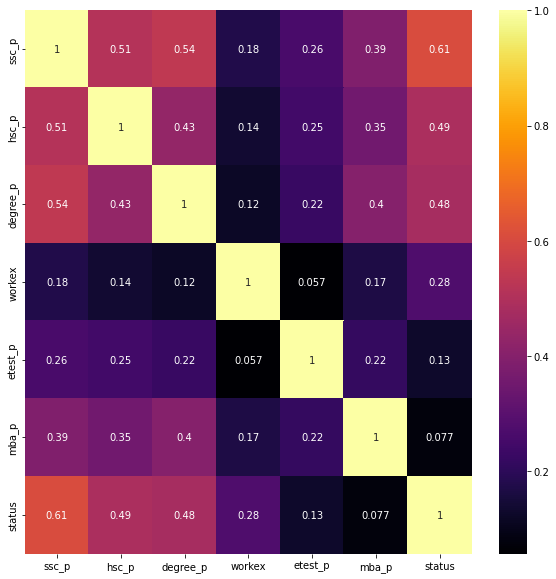

In [61]:
# create heatmap to check for correlations

corr = df.corr()

fig, ax = plt.subplots(figsize = (10, 10)) 
sns.heatmap(corr, annot = True, cmap = 'inferno')

Correlations Between features and the target 'status'

* **Strong Correlations**: Higher Secondary Education percentage('hsc_p'), Secondary Education percentage('ssc_p'), Degree Percentage('degree_p'

* **Moderate Correlations**: Work Experiece('workex'), Employability test percentage('etest_p')

[Text(0, 0, 'Not Placed'), Text(0, 0, 'Placed')]

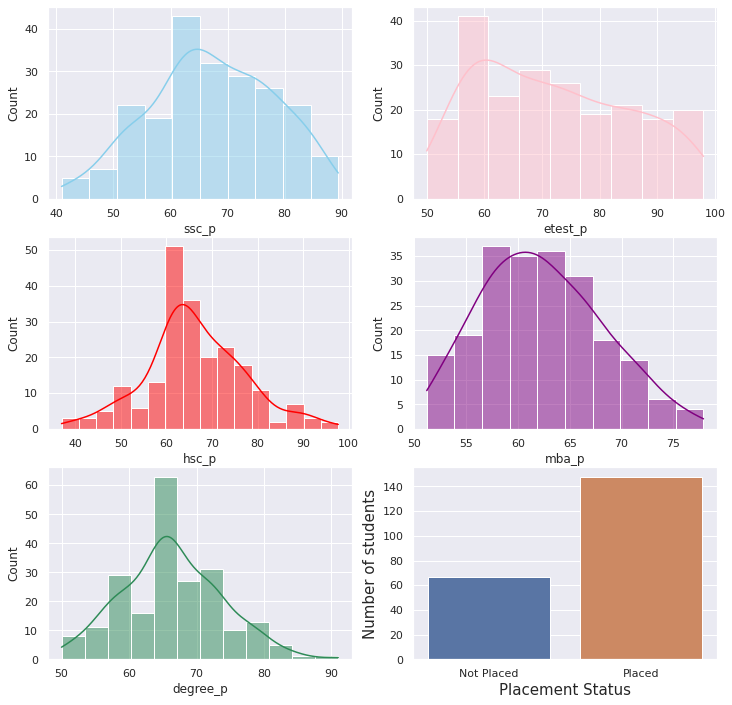

In [199]:
# create histograms for all features

sns.set(style = 'darkgrid')

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

sns.histplot(data = df, x = 'ssc_p', color ='skyblue', kde = True, ax = axs[0, 0])
sns.histplot(data = df, x = 'hsc_p', color ='red', kde = True, ax = axs[1, 0])
sns.histplot(data = df, x = 'degree_p', color ='seagreen', kde = True, ax = axs[2, 0])
sns.histplot(data = df, x = 'etest_p', color ='pink', kde = True, ax = axs[0, 1])
sns.histplot(data = df, x = 'mba_p', color ='purple', kde = True, ax = axs[1, 1])
barplot = sns.barplot(data = df, x = df['status'].value_counts(), y = df['status'].value_counts(), ax = axs[2, 1])
barplot.set_xlabel('Placement Status', fontsize = 15)
barplot.set_ylabel('Number of students', fontsize = 15)
barplot.set_xticklabels(['Not Placed', 'Placed'])

We see a dignificantly higher amount of placed students.

In [151]:
df['status'].value_counts(normalize = True)

1    0.688372
0    0.311628
Name: status, dtype: float64

We have unbalanced data

[source](https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn)